In [1]:
EXPERIMENT = '05-12'
N_SPLITS = 5
SEED = 1
CLIP_UPPER_RATE = 1.5
CLIP_LOWER_RATE = 1.0
Y_THRESHOLD = 200

In [2]:
from collections import defaultdict
import configparser
from functools import partial
from itertools import chain
import json
import logging
import os
import pickle
import re
import sys
import time

SINCE = time.time()

from catboost import CatBoostClassifier
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as mse, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearnex import patch_sklearn

config = configparser.ConfigParser()
INI_FILEPATH = os.path.join(os.path.expanduser('~'), 'aiquest2021-assesment', 'config.ini')
config.read(INI_FILEPATH)
if config['FOLDER']['SCRIPTS'] not in sys.path:
    sys.path.append(config['FOLDER']['SCRIPTS'])
from logging_util import get_logger, timer
from feature_engineering import make_or_load_features
from text_feature_extraction import make_or_load_vector

In [3]:
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
output_dir = os.path.join(config['FOLDER']['EXPERIMENTS'], EXPERIMENT)
os.makedirs(output_dir)

In [5]:
logger = get_logger(__name__, os.path.join(output_dir, 'log.log'))

# Loading

In [6]:
with timer('Load dataset', logger):
    train = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'train.csv'))
    test = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'test.csv'))
    sample_submit = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'sample_submit.csv'))

# Feature engineering

In [7]:
train_path = os.path.join(config['FOLDER']['FEATURES'], 'train_features.csv')
test_path = os.path.join(config['FOLDER']['FEATURES'], 'test_features.csv')

In [8]:
X, X_test = make_or_load_features(train, test, train_path, test_path, logger)

In [9]:
X

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month
0,0,6,2.0,0,1.0,4.0,0,0,1,1,...,0,0,0,1,2016.0,7.0,2016.0,7.0,2016.0,7.0
1,1,2,1.0,0,1.0,1.0,1,1,1,1,...,1,1,0,0,2016.0,9.0,2015.0,12.0,2017.0,3.0
2,2,2,2.0,0,1.0,1.0,1,2,1,1,...,2,2,1,0,2016.0,6.0,2016.0,5.0,2017.0,8.0
3,3,2,1.0,0,1.0,1.0,1,3,1,1,...,0,3,0,1,2014.0,3.0,2012.0,6.0,2017.0,9.0
4,4,2,1.0,0,1.0,1.0,1,2,1,1,...,2,4,0,0,2015.0,8.0,2015.0,3.0,2017.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55578,55578,4,1.5,0,1.0,1.0,1,2,1,1,...,2,95,0,0,2013.0,2.0,2013.0,1.0,2017.0,9.0
55579,55579,2,1.0,0,1.0,1.0,2,4,0,1,...,3,181,0,0,2015.0,11.0,2015.0,1.0,2016.0,10.0
55580,55580,2,1.0,0,1.0,1.0,0,3,1,1,...,0,33,0,0,2016.0,3.0,2016.0,2.0,2017.0,4.0
55581,55581,1,1.5,0,1.0,1.0,2,0,1,1,...,0,251,0,0,2016.0,10.0,2016.0,4.0,2017.0,4.0


In [10]:
X_test

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month
0,0,6,2.0,0,2.0,2.0,1,5,1,1,...,4,88,0,0,2017.0,1.0,2016.0,8.0,2017.0,9.0
1,1,3,1.0,0,1.0,1.0,2,0,1,1,...,0,16,0,0,2016.0,8.0,2014.0,9.0,2017.0,5.0
2,2,2,1.0,0,0.0,1.0,0,2,0,1,...,2,90,0,0,NaN,NaN,2012.0,10.0,NaN,NaN
3,3,4,1.0,0,1.0,2.0,1,2,0,1,...,2,44,0,0,NaN,NaN,2013.0,1.0,NaN,NaN
4,4,3,1.5,0,1.0,2.0,1,0,1,1,...,0,129,0,0,2015.0,8.0,2014.0,12.0,2016.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,18523,4,1.0,0,2.0,2.0,1,2,1,1,...,2,109,0,0,NaN,NaN,2009.0,11.0,NaN,NaN
18524,18524,2,1.0,0,2.0,1.0,0,4,0,1,...,3,22,0,1,2017.0,1.0,2017.0,1.0,2017.0,4.0
18525,18525,5,1.5,0,2.0,2.0,0,4,1,1,...,3,181,0,0,NaN,NaN,2014.0,9.0,NaN,NaN
18526,18526,2,1.0,0,1.0,2.0,1,2,1,1,...,2,158,0,0,2016.0,4.0,2014.0,3.0,2017.0,5.0


In [11]:
X.columns = [re.sub(r"[:;/']", '', c) for c in X.columns]
X_test.columns = [re.sub(r"[:;/']", '', c) for c in X.columns]

In [12]:
# Clustering
area_features = ['latitude', 'longitude']

# Onehot encoding
categorical_features = ['cancellation_policy', 'bed_type', 'city', 'neighbourhood', 'property_type',
                        'room_type', 'zipcode5', 'zipcode_1st_digit']

# They do not need to be encoded
int_flag_features = ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified',
                     'instant_bookable', 'has_thumbnail', 'zipcode_imputed']

# Already one-hot style
amenity_onehot_features = [c for c in X.columns if c.startswith('has_') and c.endswith('_amenity')]

discrete_features = categorical_features + int_flag_features + amenity_onehot_features

# Scaling, transformation
continuous_features = [
    c for c in X.columns
    if c not in discrete_features + area_features + ['id', 'y']
]

In [13]:
%%time
# Reduce dimension & whitening
## training
decomposer = PCA(n_components=0.8, random_state=SEED, whiten=True).fit(X[amenity_onehot_features])
X_amenity_components = decomposer.transform(X[amenity_onehot_features])
amenity_components_columns = [f'amenity_x{i + 1}' for i in range(decomposer.n_components_)]
X_amenity_components = pd.DataFrame(data=X_amenity_components,
                                    columns=amenity_components_columns)
X = pd.concat([X, X_amenity_components], axis=1)
# X.drop(columns=amenity_onehot_features, inplace=True)
X_test_amenity_components = decomposer.transform(X_test[amenity_onehot_features])
X_test_amenity_components = pd.DataFrame(data=X_test_amenity_components,
                                         columns=amenity_components_columns)
X_test = pd.concat([X_test, X_test_amenity_components], axis=1)
# X_test.drop(columns=amenity_onehot_features, inplace=True)

Wall time: 548 ms


In [14]:
f = lambda s1, s2: ' '.join([s1, s2])
train['name+description'] = np.vectorize(f)(train['name'], train['description'])
test['name+description'] = np.vectorize(f)(test['name'], test['description'])

In [15]:
%%time
vec_train, vec_test = make_or_load_vector(train=train,
                                          test=test,
                                          feature_dir=config['FOLDER']['FEATURES'],
                                          logger=logger,
                                          text_column='name+description',
                                          embedder='lda_count',
                                          overwrite=True,
                                          random_state=85)

Wall time: 4min 29s


In [16]:
%%time
vec_columns = vec_train.columns.tolist()

Wall time: 0 ns


In [17]:
%%time
X = pd.concat([X, vec_train], axis=1)
X_test = pd.concat([X_test, vec_test], axis=1)
X.shape, X_test.shape

Wall time: 60.7 ms


((55583, 285), (18528, 285))

In [18]:
passthrough_features = amenity_onehot_features \
                     + amenity_components_columns \
                     + int_flag_features \
                     + area_features \
                     + vec_columns

In [19]:
def get_classifier(continuous_features, discrete_features, passthrough_features, random_state):
    continuous_preprocessor = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]
    )
    categorical_preprocessor = OneHotEncoder(handle_unknown='ignore')
    preprocessor = ColumnTransformer(
        transformers=[
            ('categorical', categorical_preprocessor, continuous_features),
            ('continuous', continuous_preprocessor, discrete_features),
            ('others', 'passthrough', passthrough_features)
        ]
    )
    return Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(random_state=random_state,
                                              max_iter=1000,
                                              n_jobs=-1,
                                              class_weight='balanced'))
        ]
    )

# Cross validation

## Preparation

In [20]:
y_min, y_max = train['y'].min(), train['y'].max()  # clipping に必要

In [21]:
# ターゲットは対数変換する
y = train.set_index('id').loc[X['id']]['y']
y_log = np.log(y)
y_log

id
0        4.927254
1        3.737670
2        4.174387
3        5.111988
4        5.105945
           ...   
55578    5.828946
55579    3.401197
55580    4.605170
55581    3.637586
55582    3.912023
Name: y, Length: 55583, dtype: float64

In [22]:
# Stratified K-fold 用
y_labels = pd.cut(y_log, bins=3, labels=range(3))
y_labels

id
0        1
1        1
2        1
3        2
4        2
        ..
55578    2
55579    1
55580    1
55581    1
55582    1
Name: y, Length: 55583, dtype: category
Categories (3, int64): [0 < 1 < 2]

In [23]:
y_threshold = np.log(Y_THRESHOLD)
y_threshold

5.298317366548036

In [24]:
id_test = X_test['id'].values
id_test

array([    0,     1,     2, ..., 18525, 18526, 18527], dtype=int64)

In [25]:
train.set_index('id', inplace=True)

## Training models

In [27]:
splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
for i, (train_idx, vaild_idx) in enumerate(splitter.split(X=X, y=y_labels)):
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # 訓練データと検証データに分割
    id_train = X.iloc[train_idx]['id'].values
    X_train = X.iloc[train_idx].drop(columns=['id'])
    y_train = y_log[train_idx].values
    id_valid = X.iloc[vaild_idx]['id'].values
    X_valid = X.iloc[vaild_idx].drop(columns=['id'])
    y_valid = y_log[vaild_idx].values
    
    # モデルの訓練
    ## 分類モデルの訓練
    with timer('Training: classifier', logger):
        y_train_clf = 1 * (y_train > y_threshold)
        y_valid_clf = 1 * (y_valid > y_threshold)
        # モデル①
        class_weights = compute_class_weight(class_weight='balanced',
                                             classes=np.array([0, 1]),
                                             y=y_train_clf)
        classifier = CatBoostClassifier(n_estimators=300,
                                        cat_features=discrete_features,
                                        class_weights=class_weights,
                                        random_state=SEED)
        classifier.fit(X_train, y_train_clf)
    ## 分類モデルの評価
    with timer('Evaluate classifier', logger):
        pred_train_clf = classifier.predict(X_train)
        logger.debug('Training f1 score: {:.6f}'.format(f1_score(y_train_clf, pred_train_clf)))
        logger.debug('Training precision: {:.6f}'.format(precision_score(y_train_clf, pred_train_clf)))
        logger.debug('Training recall: {:.6f}'.format(recall_score(y_train_clf, pred_train_clf)))
        pred_valid_clf = classifier.predict(X_valid)
        logger.debug('Validation f1 score: {:.6f}'.format(f1_score(y_valid_clf, pred_valid_clf)))
        logger.debug('Validation precision: {:.6f}'.format(precision_score(y_valid_clf, pred_valid_clf)))
        logger.debug('Validation recall: {:.6f}'.format(recall_score(y_valid_clf, pred_valid_clf)))
    ## `y` 予測モデルの訓練
    with timer('Training regressor', logger):
        class1_mask = y_train > y_threshold
        estimator0 = LGBMRegressor(n_estimators=300,
                                   random_state=SEED,
                                   n_jobs=-1,
                                   learning_rate=0.1,
                                   importance_type='gain')
        estimator0.fit(X_train[~class1_mask], y_train[~class1_mask], categorical_feature=discrete_features)
        estimator1 = LGBMRegressor(n_estimators=300,
                                   random_state=SEED,
                                   n_jobs=-1,
                                   learning_rate=0.1,
                                   importance_type='gain')
        estimator1.fit(X_train[class1_mask], y_train[class1_mask], categorical_feature=discrete_features)
        
    # 予測結果を保存する
    with timer('Prediction', logger):
        # 訓練データ
        proba_train = classifier.predict_proba(X_train)
        pred_train0 = estimator0.predict(X_train)
        pred_train1 = estimator1.predict(X_train)
        pred_train = pred_train0 * proba_train[:, 0] + pred_train1 * proba_train[:, 1]
        pred_train = pd.DataFrame(data=pred_train, columns=['pred'])
        pred_train['pred'] = np.exp(pred_train['pred'])
        pred_train['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
        # 検証データ
        proba_valid = classifier.predict_proba(X_valid)
        pred_valid0 = estimator0.predict(X_valid)
        pred_valid1 = estimator1.predict(X_valid)
        pred_valid = pred_valid0 * proba_valid[:, 0] + pred_valid1 * proba_valid[:, 1]
        pred_valid = pd.DataFrame(data=pred_valid, columns=['pred'])
        pred_valid['pred'] = np.exp(pred_valid['pred'])
        pred_valid['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
        # テストデータ
        proba_test = classifier.predict_proba(X_test.drop(columns=['id']))
        pred_test0 = estimator0.predict(X_test.drop(columns=['id']))
        pred_test1 = estimator1.predict(X_test.drop(columns=['id']))
        pred_test = pred_test0 * proba_test[:, 0] + pred_test1 * proba_test[:, 1]
        pred_test = pd.DataFrame(data=pred_test, columns=['pred'])
        pred_test['pred'] = np.exp(pred_test['pred'])
        pred_test['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
    with timer('Save prediction', logger):
        ## 訓練データ
        pred_train['id'] = id_train
        pred_train.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_training.csv'), index=False)
        ## 検証データ
        pred_valid['id'] = id_valid
        pred_valid.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv'), index=False)
        ## テストデータ
        pred_test['id'] = id_test
        pred_test.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_test.csv'), index=False)
    ## モデルの保存
    with timer('Save model', logger):
        filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
        with open(filepath_fold_model, 'wb') as f:
            pickle.dump({
                'class0': estimator0,
                'class1': estimator1,
                'classifier': classifier
            }, f)
    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

Learning rate set to 0.15708
0:	learn: 0.6035259	total: 259ms	remaining: 1m 17s
1:	learn: 0.5489997	total: 330ms	remaining: 49.2s
2:	learn: 0.5046451	total: 408ms	remaining: 40.4s
3:	learn: 0.4698479	total: 490ms	remaining: 36.2s
4:	learn: 0.4437891	total: 561ms	remaining: 33.1s
5:	learn: 0.4252645	total: 634ms	remaining: 31.1s
6:	learn: 0.4119605	total: 716ms	remaining: 30s
7:	learn: 0.4033982	total: 793ms	remaining: 29s
8:	learn: 0.3948567	total: 874ms	remaining: 28.3s
9:	learn: 0.3874185	total: 950ms	remaining: 27.6s
10:	learn: 0.3818795	total: 1.03s	remaining: 27s
11:	learn: 0.3767016	total: 1.12s	remaining: 27s
12:	learn: 0.3721901	total: 1.21s	remaining: 26.6s
13:	learn: 0.3690480	total: 1.28s	remaining: 26.2s
14:	learn: 0.3654570	total: 1.36s	remaining: 25.9s
15:	learn: 0.3627091	total: 1.45s	remaining: 25.7s
16:	learn: 0.3606252	total: 1.52s	remaining: 25.4s
17:	learn: 0.3583190	total: 1.64s	remaining: 25.6s
18:	learn: 0.3559129	total: 1.71s	remaining: 25.3s
19:	learn: 0.354325

164:	learn: 0.2605335	total: 12.4s	remaining: 10.1s
165:	learn: 0.2602210	total: 12.4s	remaining: 10s
166:	learn: 0.2598461	total: 12.5s	remaining: 9.96s
167:	learn: 0.2595939	total: 12.6s	remaining: 9.88s
168:	learn: 0.2592512	total: 12.6s	remaining: 9.8s
169:	learn: 0.2588616	total: 12.7s	remaining: 9.72s
170:	learn: 0.2586245	total: 12.8s	remaining: 9.64s
171:	learn: 0.2581575	total: 12.9s	remaining: 9.56s
172:	learn: 0.2577483	total: 12.9s	remaining: 9.48s
173:	learn: 0.2573245	total: 13s	remaining: 9.42s
174:	learn: 0.2569779	total: 13.1s	remaining: 9.34s
175:	learn: 0.2566716	total: 13.1s	remaining: 9.26s
176:	learn: 0.2563249	total: 13.2s	remaining: 9.18s
177:	learn: 0.2557725	total: 13.3s	remaining: 9.1s
178:	learn: 0.2552990	total: 13.3s	remaining: 9.02s
179:	learn: 0.2550281	total: 13.4s	remaining: 8.94s
180:	learn: 0.2546212	total: 13.5s	remaining: 8.87s
181:	learn: 0.2541518	total: 13.6s	remaining: 8.79s
182:	learn: 0.2537687	total: 13.6s	remaining: 8.71s
183:	learn: 0.2534

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Learning rate set to 0.15708
0:	learn: 0.6005289	total: 74.4ms	remaining: 22.3s
1:	learn: 0.5426722	total: 146ms	remaining: 21.8s
2:	learn: 0.5036535	total: 225ms	remaining: 22.3s
3:	learn: 0.4629912	total: 292ms	remaining: 21.6s
4:	learn: 0.4374776	total: 358ms	remaining: 21.1s
5:	learn: 0.4209985	total: 426ms	remaining: 20.9s
6:	learn: 0.4087424	total: 498ms	remaining: 20.9s
7:	learn: 0.4001349	total: 565ms	remaining: 20.6s
8:	learn: 0.3926665	total: 632ms	remaining: 20.4s
9:	learn: 0.3858350	total: 706ms	remaining: 20.5s
10:	learn: 0.3794255	total: 777ms	remaining: 20.4s
11:	learn: 0.3736739	total: 850ms	remaining: 20.4s
12:	learn: 0.3697639	total: 929ms	remaining: 20.5s
13:	learn: 0.3653718	total: 999ms	remaining: 20.4s
14:	learn: 0.3622393	total: 1.07s	remaining: 20.3s
15:	learn: 0.3591409	total: 1.16s	remaining: 20.5s
16:	learn: 0.3568997	total: 1.23s	remaining: 20.6s
17:	learn: 0.3548420	total: 1.31s	remaining: 20.6s
18:	learn: 0.3529772	total: 1.39s	remaining: 20.5s
19:	learn: 

161:	learn: 0.2599492	total: 11.7s	remaining: 9.99s
162:	learn: 0.2595392	total: 11.8s	remaining: 9.93s
163:	learn: 0.2590788	total: 11.9s	remaining: 9.85s
164:	learn: 0.2585934	total: 12s	remaining: 9.78s
165:	learn: 0.2580905	total: 12s	remaining: 9.71s
166:	learn: 0.2576950	total: 12.1s	remaining: 9.63s
167:	learn: 0.2572984	total: 12.2s	remaining: 9.56s
168:	learn: 0.2568382	total: 12.2s	remaining: 9.49s
169:	learn: 0.2564885	total: 12.3s	remaining: 9.41s
170:	learn: 0.2560686	total: 12.4s	remaining: 9.34s
171:	learn: 0.2555663	total: 12.5s	remaining: 9.27s
172:	learn: 0.2550659	total: 12.5s	remaining: 9.2s
173:	learn: 0.2547900	total: 12.6s	remaining: 9.13s
174:	learn: 0.2545776	total: 12.7s	remaining: 9.05s
175:	learn: 0.2539606	total: 12.7s	remaining: 8.98s
176:	learn: 0.2536052	total: 12.8s	remaining: 8.9s
177:	learn: 0.2532766	total: 12.9s	remaining: 8.83s
178:	learn: 0.2527982	total: 13s	remaining: 8.76s
179:	learn: 0.2523409	total: 13s	remaining: 8.68s
180:	learn: 0.2520479	

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Learning rate set to 0.15708
0:	learn: 0.6066877	total: 74ms	remaining: 22.1s
1:	learn: 0.5434042	total: 150ms	remaining: 22.3s
2:	learn: 0.4958699	total: 227ms	remaining: 22.5s
3:	learn: 0.4630656	total: 294ms	remaining: 21.7s
4:	learn: 0.4408178	total: 366ms	remaining: 21.6s
5:	learn: 0.4240673	total: 434ms	remaining: 21.3s
6:	learn: 0.4103731	total: 512ms	remaining: 21.4s
7:	learn: 0.4000052	total: 587ms	remaining: 21.4s
8:	learn: 0.3918199	total: 655ms	remaining: 21.2s
9:	learn: 0.3853843	total: 727ms	remaining: 21.1s
10:	learn: 0.3799418	total: 797ms	remaining: 20.9s
11:	learn: 0.3752048	total: 896ms	remaining: 21.5s
12:	learn: 0.3712164	total: 963ms	remaining: 21.3s
13:	learn: 0.3681232	total: 1.03s	remaining: 21s
14:	learn: 0.3655454	total: 1.1s	remaining: 20.8s
15:	learn: 0.3619226	total: 1.17s	remaining: 20.8s
16:	learn: 0.3590910	total: 1.25s	remaining: 20.7s
17:	learn: 0.3572676	total: 1.32s	remaining: 20.7s
18:	learn: 0.3554556	total: 1.4s	remaining: 20.6s
19:	learn: 0.3532

164:	learn: 0.2597612	total: 12s	remaining: 9.82s
165:	learn: 0.2593893	total: 12.1s	remaining: 9.75s
166:	learn: 0.2590190	total: 12.1s	remaining: 9.68s
167:	learn: 0.2584679	total: 12.2s	remaining: 9.6s
168:	learn: 0.2580668	total: 12.3s	remaining: 9.53s
169:	learn: 0.2576548	total: 12.4s	remaining: 9.46s
170:	learn: 0.2572584	total: 12.4s	remaining: 9.38s
171:	learn: 0.2570843	total: 12.5s	remaining: 9.3s
172:	learn: 0.2566372	total: 12.6s	remaining: 9.23s
173:	learn: 0.2562856	total: 12.6s	remaining: 9.15s
174:	learn: 0.2559809	total: 12.7s	remaining: 9.07s
175:	learn: 0.2556138	total: 12.8s	remaining: 9s
176:	learn: 0.2553046	total: 12.8s	remaining: 8.93s
177:	learn: 0.2548753	total: 12.9s	remaining: 8.85s
178:	learn: 0.2544811	total: 13s	remaining: 8.78s
179:	learn: 0.2540961	total: 13.1s	remaining: 8.71s
180:	learn: 0.2536028	total: 13.1s	remaining: 8.63s
181:	learn: 0.2530971	total: 13.2s	remaining: 8.56s
182:	learn: 0.2527482	total: 13.3s	remaining: 8.48s
183:	learn: 0.2523080

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Learning rate set to 0.157082
0:	learn: 0.6039970	total: 70.6ms	remaining: 21.1s
1:	learn: 0.5475317	total: 145ms	remaining: 21.6s
2:	learn: 0.4958343	total: 216ms	remaining: 21.4s
3:	learn: 0.4613160	total: 291ms	remaining: 21.5s
4:	learn: 0.4388806	total: 371ms	remaining: 21.9s
5:	learn: 0.4235093	total: 443ms	remaining: 21.7s
6:	learn: 0.4107576	total: 516ms	remaining: 21.6s
7:	learn: 0.4020697	total: 584ms	remaining: 21.3s
8:	learn: 0.3941771	total: 656ms	remaining: 21.2s
9:	learn: 0.3870815	total: 731ms	remaining: 21.2s
10:	learn: 0.3821296	total: 800ms	remaining: 21s
11:	learn: 0.3759741	total: 871ms	remaining: 20.9s
12:	learn: 0.3703252	total: 946ms	remaining: 20.9s
13:	learn: 0.3669161	total: 1.02s	remaining: 20.8s
14:	learn: 0.3630308	total: 1.09s	remaining: 20.7s
15:	learn: 0.3604730	total: 1.15s	remaining: 20.5s
16:	learn: 0.3583077	total: 1.23s	remaining: 20.5s
17:	learn: 0.3557461	total: 1.3s	remaining: 20.4s
18:	learn: 0.3534479	total: 1.38s	remaining: 20.4s
19:	learn: 0.

163:	learn: 0.2581211	total: 12s	remaining: 9.92s
164:	learn: 0.2577576	total: 12s	remaining: 9.84s
165:	learn: 0.2573164	total: 12.1s	remaining: 9.78s
166:	learn: 0.2568466	total: 12.2s	remaining: 9.7s
167:	learn: 0.2565234	total: 12.2s	remaining: 9.62s
168:	learn: 0.2562353	total: 12.3s	remaining: 9.55s
169:	learn: 0.2555935	total: 12.4s	remaining: 9.48s
170:	learn: 0.2554337	total: 12.5s	remaining: 9.4s
171:	learn: 0.2549063	total: 12.5s	remaining: 9.32s
172:	learn: 0.2544531	total: 12.6s	remaining: 9.26s
173:	learn: 0.2539224	total: 12.7s	remaining: 9.19s
174:	learn: 0.2535829	total: 12.8s	remaining: 9.12s
175:	learn: 0.2532117	total: 12.8s	remaining: 9.04s
176:	learn: 0.2527542	total: 12.9s	remaining: 8.96s
177:	learn: 0.2524214	total: 13s	remaining: 8.89s
178:	learn: 0.2520719	total: 13.1s	remaining: 8.82s
179:	learn: 0.2516547	total: 13.1s	remaining: 8.75s
180:	learn: 0.2512034	total: 13.2s	remaining: 8.67s
181:	learn: 0.2506961	total: 13.3s	remaining: 8.6s
182:	learn: 0.2502856

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Learning rate set to 0.157082
0:	learn: 0.6062711	total: 71ms	remaining: 21.2s
1:	learn: 0.5458122	total: 138ms	remaining: 20.5s
2:	learn: 0.4955782	total: 211ms	remaining: 20.9s
3:	learn: 0.4613985	total: 286ms	remaining: 21.1s
4:	learn: 0.4374660	total: 349ms	remaining: 20.6s
5:	learn: 0.4199004	total: 421ms	remaining: 20.6s
6:	learn: 0.4081501	total: 509ms	remaining: 21.3s
7:	learn: 0.3995746	total: 575ms	remaining: 21s
8:	learn: 0.3921485	total: 649ms	remaining: 21s
9:	learn: 0.3872834	total: 715ms	remaining: 20.7s
10:	learn: 0.3811460	total: 788ms	remaining: 20.7s
11:	learn: 0.3761464	total: 862ms	remaining: 20.7s
12:	learn: 0.3720166	total: 946ms	remaining: 20.9s
13:	learn: 0.3687594	total: 1.02s	remaining: 20.8s
14:	learn: 0.3645864	total: 1.1s	remaining: 20.9s
15:	learn: 0.3619032	total: 1.17s	remaining: 20.7s
16:	learn: 0.3596171	total: 1.24s	remaining: 20.6s
17:	learn: 0.3575720	total: 1.32s	remaining: 20.7s
18:	learn: 0.3544411	total: 1.39s	remaining: 20.6s
19:	learn: 0.3524

162:	learn: 0.2601855	total: 11.8s	remaining: 9.95s
163:	learn: 0.2598340	total: 11.9s	remaining: 9.87s
164:	learn: 0.2592954	total: 12s	remaining: 9.8s
165:	learn: 0.2588762	total: 12s	remaining: 9.72s
166:	learn: 0.2583126	total: 12.1s	remaining: 9.65s
167:	learn: 0.2578406	total: 12.2s	remaining: 9.58s
168:	learn: 0.2574761	total: 12.3s	remaining: 9.5s
169:	learn: 0.2572305	total: 12.3s	remaining: 9.43s
170:	learn: 0.2566428	total: 12.4s	remaining: 9.36s
171:	learn: 0.2563153	total: 12.5s	remaining: 9.28s
172:	learn: 0.2559182	total: 12.5s	remaining: 9.21s
173:	learn: 0.2555413	total: 12.6s	remaining: 9.13s
174:	learn: 0.2550577	total: 12.7s	remaining: 9.06s
175:	learn: 0.2547784	total: 12.8s	remaining: 8.99s
176:	learn: 0.2543933	total: 12.8s	remaining: 8.91s
177:	learn: 0.2539414	total: 12.9s	remaining: 8.84s
178:	learn: 0.2536271	total: 13s	remaining: 8.76s
179:	learn: 0.2533142	total: 13s	remaining: 8.69s
180:	learn: 0.2528759	total: 13.1s	remaining: 8.62s
181:	learn: 0.2524409	

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


## Evaluation

In [28]:
rmse = partial(mse, squared=False)

In [29]:
metrics = defaultdict(list)

### Training set

In [30]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_training.csv'))
    pred_df['actual'] = train.loc[pred_df['id'], 'y'].values
    cv_loss = rmse(pred_df['actual'], pred_df['pred'])
    logger.info('CV fold {} training loss={:.7f}'.format(num_fold, cv_loss))
    metrics['train_losses'].append(cv_loss)
    pred_train_dfs.append(pred_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])

logger.info('CV training loss: average={:.7f}, std={:.7f}' \
            .format(metrics['train_losses_avg'], metrics['train_losses_std']))

2021-08-09 06:14:15,438 - __main__ - INFO - CV fold 1 training loss=63.6481829
2021-08-09 06:14:15,465 - __main__ - INFO - CV fold 2 training loss=62.7445461
2021-08-09 06:14:15,489 - __main__ - INFO - CV fold 3 training loss=62.5370630
2021-08-09 06:14:15,511 - __main__ - INFO - CV fold 4 training loss=61.9216694
2021-08-09 06:14:15,534 - __main__ - INFO - CV fold 5 training loss=61.3515751
2021-08-09 06:14:15,536 - __main__ - INFO - CV training loss: average=62.4406073, std=0.7765577


In [31]:
pred_train = pd.concat(pred_train_dfs).groupby('id').sum()
pred_train = pred_train / N_SPLITS
pred_train['actual'] = train.loc[pred_train.index, 'y'].values
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))

In [32]:
train_loss = rmse(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = train_loss
logger.info('Training loss: {:.7f}'.format(train_loss))

2021-08-09 06:14:15,757 - __main__ - INFO - Training loss: 78.8749502


### Validation set

In [33]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv'))
    pred_df['actual'] = train.loc[pred_df['id'], 'y'].values
    cv_loss = rmse(pred_df['actual'], pred_df['pred'])
    logger.info('CV fold {} validation loss={:.7f}'.format(num_fold, cv_loss))
    metrics['valid_losses'].append(cv_loss)
    pred_valid_dfs.append(pred_df)

metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])

logger.info('CV validation loss: average={:.7f}, std={:.7f}' \
            .format(metrics['valid_losses_avg'], metrics['valid_losses_std']))

2021-08-09 06:14:15,794 - __main__ - INFO - CV fold 1 validation loss=99.9206957
2021-08-09 06:14:15,810 - __main__ - INFO - CV fold 2 validation loss=101.5214927
2021-08-09 06:14:15,829 - __main__ - INFO - CV fold 3 validation loss=105.0655543
2021-08-09 06:14:15,846 - __main__ - INFO - CV fold 4 validation loss=105.1430691
2021-08-09 06:14:15,864 - __main__ - INFO - CV fold 5 validation loss=107.8921710
2021-08-09 06:14:15,866 - __main__ - INFO - CV validation loss: average=103.9085966, std=2.8401746


In [34]:
pred_valid = pd.concat(pred_valid_dfs).groupby('id').sum()
pred_valid = pred_valid / N_SPLITS
pred_valid['actual'] = train.loc[pred_valid.index, 'y'].values
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))

In [35]:
valid_loss = rmse(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = valid_loss
logger.info('Validation loss: {:.7f}'.format(valid_loss))

2021-08-09 06:14:16,075 - __main__ - INFO - Validation loss: 196.4036820


In [36]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(metrics, f)

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


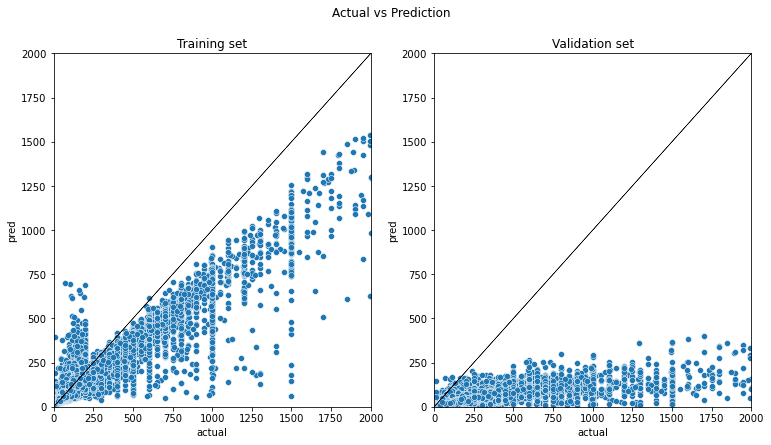

In [37]:
fig = plt.figure(figsize=(12.5, 6.5))
plt.suptitle('Actual vs Prediction')

plt.subplot(1, 2, 1)
ax = sns.scatterplot(pred_train['actual'], pred_train['pred'])
plt.plot(pred_train['actual'], pred_train['actual'], color='black', linewidth=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
ax.set_title('Training set');
# plt.axes().set_aspect('equal')
plt.subplot(1, 2, 2)
ax = sns.scatterplot(pred_valid['actual'], pred_valid['pred'])
plt.plot(pred_valid['actual'], pred_valid['actual'], color='black', linewidth=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
plt.title('Validation set');

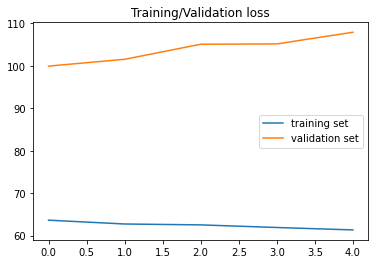

In [38]:
plt.plot(metrics['train_losses'], label='training set')
plt.plot(metrics['valid_losses'], label='validation set')
plt.title('Training/Validation loss')
plt.legend();

# Submission

In [39]:
pred_test_dfs = [pd.read_csv(os.path.join(output_dir, f'cv_fold{i + 1}_test.csv')) for i in range(N_SPLITS)]

In [40]:
pred_test = pd.concat(pred_test_dfs).groupby('id').sum()
pred_test = pred_test / N_SPLITS

In [41]:
pred_test.to_csv(os.path.join(output_dir, f'{EXPERIMENT}_submission.csv'), header=None)

# Visualization

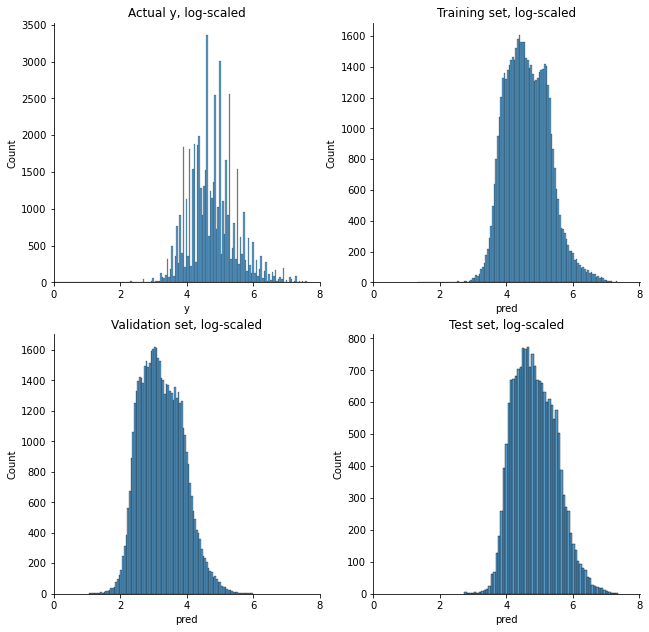

In [42]:
ylim_min, ylim_max = np.log(y_min * CLIP_LOWER_RATE), np.log(y_max * CLIP_UPPER_RATE)
fig = plt.figure(figsize=(10.5, 10.5))
plt.subplot(2, 2, 1)
ax = sns.histplot(y_log)
ax.set_title('Actual y, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 2)
ax = sns.histplot(np.log(pred_train['pred']))
ax.set_title('Training set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 3)
ax = sns.histplot(np.log(pred_valid['pred']))
ax.set_title('Validation set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 4)
ax = sns.histplot(np.log(pred_test['pred']))
ax.set_title('Test set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

fig.savefig(os.path.join(output_dir, 'figure.png'))

In [43]:
logger.debug('Complete({:.3f} seconds passed)'.format(time.time() - SINCE))

# Feature importance

In [44]:
pd.options.display.float_format = '{:.5f}'.format

In [45]:
models = []
for i, (train_idx, vaild_idx) in enumerate(splitter.split(X=X, y=y_labels)):
    num_fold = i + 1

    ## モデルの保存
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
    with open(filepath_fold_model, 'rb') as f:
        model = pickle.load(f)
    models.append(model)

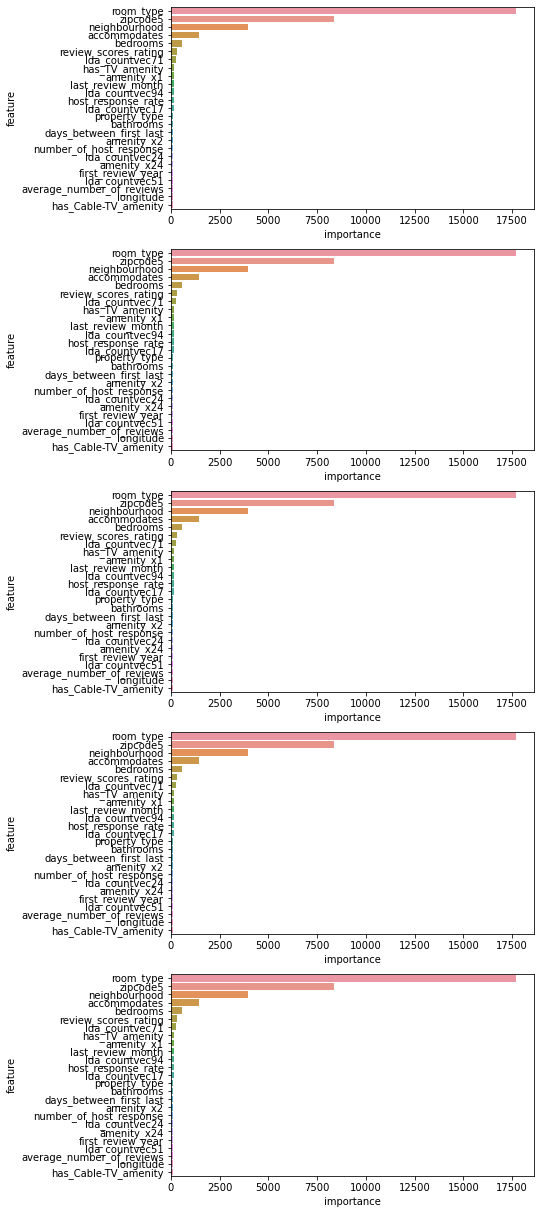

In [46]:
fig = plt.figure(figsize=(6.5, 21.5))
for i in range(N_SPLITS):
    plt.subplot(5, 1, i + 1)
    imp_df = pd.DataFrame(data=model['class0'].feature_importances_, columns=['importance'])
    imp_df['feature'] = X_train.columns.tolist()
    imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
    sns.barplot(data=imp_df.head(25), y='feature', x='importance')
fig.savefig(os.path.join(output_dir, 'feature_importance0.png'))

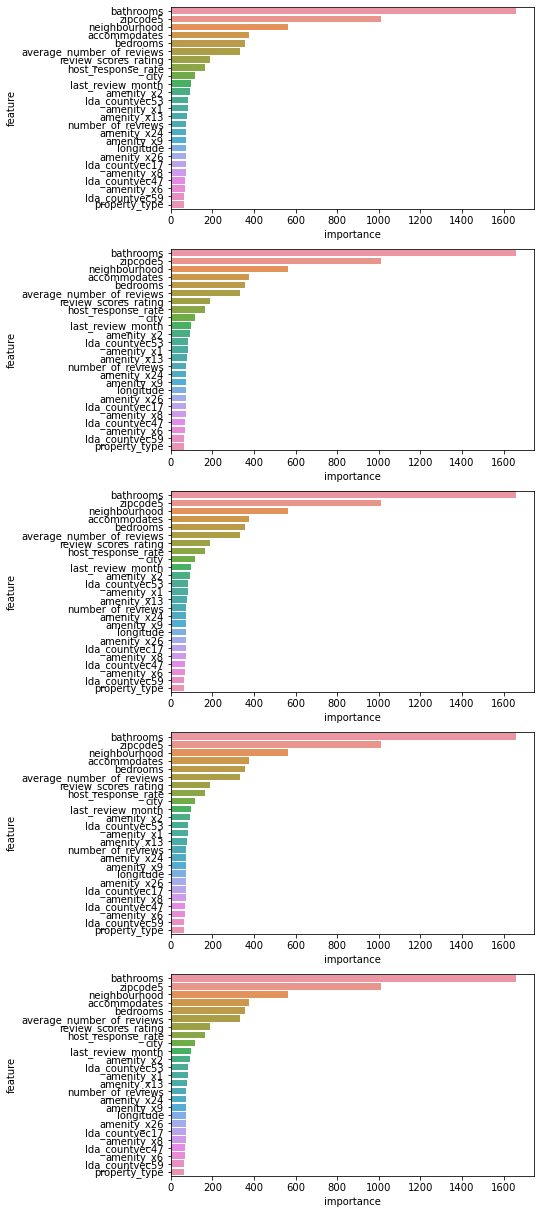

In [47]:
fig = plt.figure(figsize=(6.5, 21.5))
for i in range(N_SPLITS):
    plt.subplot(5, 1, i + 1)
    imp_df = pd.DataFrame(data=model['class1'].feature_importances_, columns=['importance'])
    imp_df['feature'] = X_train.columns.tolist()
    imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
    sns.barplot(data=imp_df.head(25), y='feature', x='importance')
fig.savefig(os.path.join(output_dir, 'feature_importance0.png'))

# Error

In [48]:
pred_valid = pd.read_csv(os.path.join(output_dir, 'prediction_valid.csv'))

In [49]:
pred_valid['diff'] = pred_valid['pred'] - pred_valid['actual']

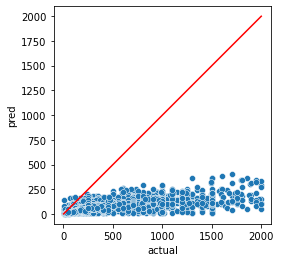

In [50]:
fig = plt.figure()
plt.axes().set_aspect('equal')
ax = sns.scatterplot(data=pred_valid, x='actual', y='pred')
ax = sns.lineplot(data=pred_valid, x='actual', y='actual', color='red')
fig.savefig(os.path.join(output_dir, 'compare_actual_prediction.png'))

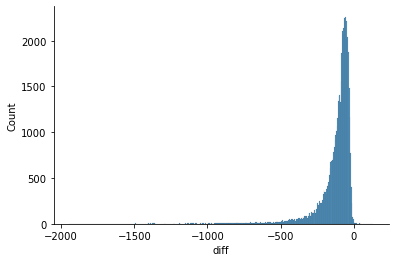

In [51]:
pred_valid.describe()
sns.histplot(data=pred_valid, x='diff')
sns.despine()

In [52]:
diff_df = pd.merge(X, pred_valid[['id', 'diff']]).set_index('id')

In [53]:
%%time
import sweetviz
report = sweetviz.analyze(diff_df, target_feat='diff', pairwise_analysis='off')
report.show_html(os.path.join(output_dir, ('sweetviz_error_report.html')))

                                             |                                             | [  0%]   00:00 ->…

Report C:\Users\nndropout\aiquest2021-assesment\experiments\05-12\sweetviz_error_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Wall time: 1min 59s


In [54]:
pd.options.display.max_rows = 50
pd.options.display.max_columns = diff_df.shape[1]

In [55]:
diff_df.sort_values('diff').head(50)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [56]:
diff_df.sort_values('diff').tail(50)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [57]:
diff_df.corr()

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [58]:
diff_df.corr().sort_values('diff')['diff'].head(50)

accommodates                           -0.47760
bedrooms                               -0.45502
bathrooms                              -0.42054
beds                                   -0.39826
room_type                              -0.26408
lda_countvec17                         -0.24462
has_Familykid-friendly_amenity         -0.19047
has_Indoor-fireplace_amenity           -0.16740
has_TV_amenity                         -0.16018
has_Cable-TV_amenity                   -0.15542
has_Dryer_amenity                      -0.14093
lda_countvec92                         -0.13823
amenity_x1                             -0.13795
has_Washer_amenity                     -0.13790
has_Suitable-for-events_amenity        -0.13670
lda_countvec47                         -0.12583
amenity_x3                             -0.11328
has_thumbnail                          -0.10992
lda_countvec71                         -0.10042
lda_countvec53                         -0.09742
lda_countvec6                          -

In [59]:
from lightgbm import LGBMRegressor
estimator = LGBMRegressor(random_state=SEED, n_jobs=-1, importance_type='gain').fit(diff_df.drop(columns=['diff']), diff_df['diff'])

In [60]:
imp_df = pd.DataFrame(data=estimator.feature_importances_, columns=['importance'])

In [61]:
imp_df['feature'] = estimator.feature_name_

In [62]:
imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
imp_df

,importance,feature
3,965847367.60156,bedrooms
1,549287419.29688,bathrooms
0,517067906.29688,accommodates
18,248919936.00000,room_type
13,228115713.70312,longitude
...,...,...
61,0.00000,has_BBQ-grill_amenity
92,0.00000,has_Air-purifier_amenity
107,0.00000,has_Accessible-height-toilet_amenity
79,0.00000,has_Accessible-height-bed_amenity


In [63]:
imp_df.to_csv(os.path.join(output_dir, 'diff_feature_importances.csv'), index=False)